In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import xgcm
import gsw
from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec
import cmocean.cm as cmo
plt.rcParams['font.size']=14

In [2]:
#constants through out this notebook
# derive the thermal wind based on a linear EOS
g=9.81
f=gsw.f(-65) 
alpha0=1e-4
rho0=1035

# Compute mean sections - only once

In [3]:
dst=xr.open_mfdataset('/media/disk3/birte/TS_Section_155E/vosaline_*.nc')
dst.coords['year']=dst.time_counter.dt.year
ds=dst.isel(time_counter=slice(2,-5))


KeyboardInterrupt



In [ ]:
dsm=ds.mean(dim='time_counter')
dsm.to_netcdf('./Smeansection.nc')

In [ ]:
dst=xr.open_mfdataset('/media/disk3/birte/TS_Section_155E/votemper_*.nc')
dst.coords['year']=dst.time_counter.dt.year
ds=dst.isel(time_counter=slice(2,-5))

In [ ]:
dsm=ds.mean(dim='time_counter')
dsm.to_netcdf('./Tmeansection.nc')

In [ ]:
dst=xr.open_mfdataset('/media/disk3/birte/TS_Section_155E/uvel_*.nc')
dst.coords['year']=dst.time_counter.dt.year
ds=dst.isel(time_counter=slice(2,-5))

In [ ]:
dsm=ds.mean(dim='time_counter')
dsm.to_netcdf('./Umeansection.nc')

# now interpolate u on t  grid

In [4]:
dst=xr.open_mfdataset('./[T,S]meansection.nc')

In [5]:
dsu=xr.open_mfdataset('./Umeansection.nc')
dsu['x']=dsu.nav_lon.isel(y=100)


In [6]:
# interpolate u on to t grid
dsui=dsu.interp(x=dst.nav_lon)
ds=xr.merge((dst,dsui))


In [7]:
ds.nav_lon.isel(y=0).values

array([15.5])

# Now get data on MITgcm grid

In [8]:
#convert lon lat to distance

dist_y=gsw.distance(ds.nav_lon.isel(x=0).values,ds.nav_lat.isel(x=0).values)
cumdist_y=np.zeros(len(ds.y))
cumdist_y[1:]=dist_y.cumsum()#+0.4e6
ds.coords['cumdist_y']=ds.y*0+cumdist_y

In [9]:
cumdist_y.max()

1531508.3769070609

In [10]:
# MITgcm grid

# horizontal grid cells
nx = 60
ny = 40

# choose vertical resolution
dr=np.array(50*np.ones(100))
nr = len(dr)
rF = (np.insert(np.cumsum(dr),0,0)) # z-coordinates of vertical cell faces
z = np.diff(rF)/2 + rF[:-1]         # z-coordinates of vertical cell centers
H = -np.sum(dr)  
print(H)
# horizontal resoluiton in km 25
dx=25
dy=25
X=np.arange(0,nx*dx,dx)
Y=np.arange(0,ny*dx,dy)

-5000.0


In [11]:
# replace x indx by distance so I can interpolate
#ds['x_grid_T']=ds.cumdist_x
ds['y']=ds.cumdist_y
dsf = ds.interpolate_na(dim="y")
dsi=dsf.interp(y=Y*10e2,deptht=z)
dsi

<xarray.Dataset>
Dimensions:      (y: 40, x: 1, deptht: 100)
Coordinates:
    nav_lon      (y, x) float32 dask.array<chunksize=(40, 1), meta=np.ndarray>
  * x            (x) int32 3632
    cumdist_y    (y) float64 0.0 2.5e+04 5e+04 ... 9.25e+05 9.5e+05 9.75e+05
    nav_lat      (y, x) float32 dask.array<chunksize=(40, 1), meta=np.ndarray>
  * y            (y) float64 0.0 2.5e+04 5e+04 ... 9.25e+05 9.5e+05 9.75e+05
  * deptht       (deptht) float64 25.0 75.0 125.0 ... 4.925e+03 4.975e+03
Data variables:
    vosaline     (deptht, y, x) float32 dask.array<chunksize=(100, 40, 1), meta=np.ndarray>
    votemper     (deptht, y, x) float32 dask.array<chunksize=(100, 40, 1), meta=np.ndarray>
    sotkeavmu1   (y, x) float32 dask.array<chunksize=(40, 1), meta=np.ndarray>
    sotkeavmu15  (y, x) float32 dask.array<chunksize=(40, 1), meta=np.ndarray>
    sotkeavmu30  (y, x) float32 dask.array<chunksize=(40, 1), meta=np.ndarray>
    sotkeavmu50  (y, x) float32 dask.array<chunksize=(40, 1), meta=np.ndarray>
    sozotaux     (y, x) float32 dask.array<chunksize=(40, 1), meta=np.ndarray>
    vozocrtx     (deptht, y, x) float32 dask.array<chunksize=(100, 40, 1), meta=np.ndarray>

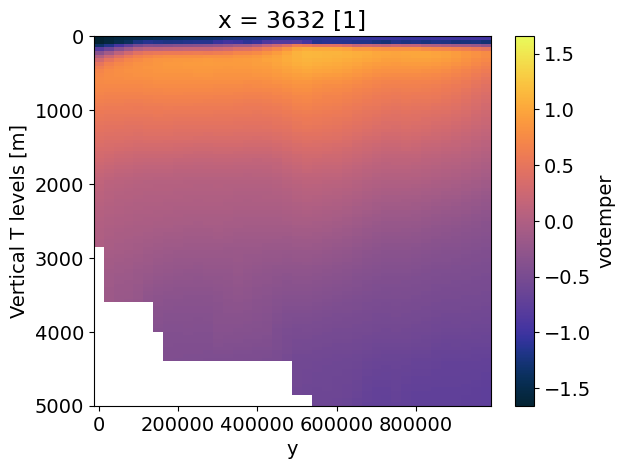

In [12]:
dsi.votemper.isel(x=0).plot.pcolormesh(cmap=cmo.thermal)
plt.gca().invert_yaxis()

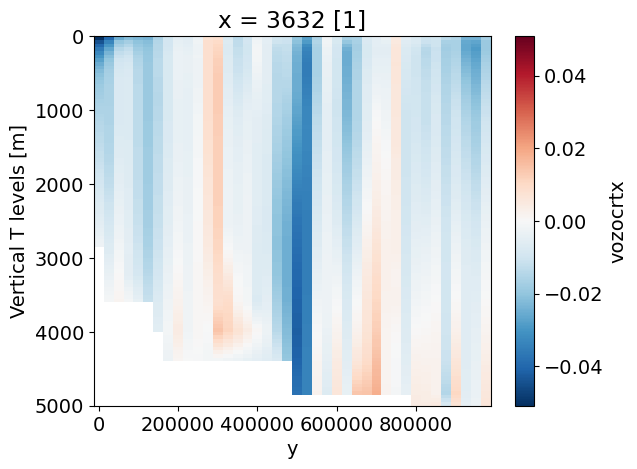

In [13]:
dsi.vozocrtx.isel(x=0).plot.pcolormesh()
plt.gca().invert_yaxis()

In [14]:
T_int=dsi.votemper*np.nan
S_int=dsi.vosaline*np.nan
T_int.shape

for kk in range(0,100):
    tt=dsi.votemper.isel(deptht=kk)
    ss=dsi.vosaline.isel(deptht=kk)
    a=np.where(~np.isnan(tt))[0]
    #print(a[0],a[-1])
    if a[-1]==39:
        tt=xr.where(~np.isnan(tt),
        tt,
        tt.isel(y=a[0]))
        ss=xr.where(~np.isnan(ss),
        ss,
        ss.isel(y=a[0]))
    else:
        tt[:a[-1]]=xr.where(~np.isnan(tt.isel(y=slice(0,a[-1]))),
        tt.isel(y=slice(0,a[-1])),
        tt.isel(y=a[0]))    
        tt[a[-1]:]=xr.where(~np.isnan(tt.isel(y=slice(a[-1],None,None))),
        tt.isel(y=slice(a[-1],None,None)),
        tt.isel(y=a[-1]))  
        ss[:a[-1]]=xr.where(~np.isnan(ss.isel(y=slice(0,a[-1]))),
        ss.isel(y=slice(0,a[-1])),
        ss.isel(y=a[0]))    
        ss[a[-1]:]=xr.where(~np.isnan(ss.isel(y=slice(a[-1],None,None))),
        ss.isel(y=slice(a[-1],None,None)),
        ss.isel(y=a[-1]))  
    T_int[kk,:]=tt
    S_int[kk,:]=ss



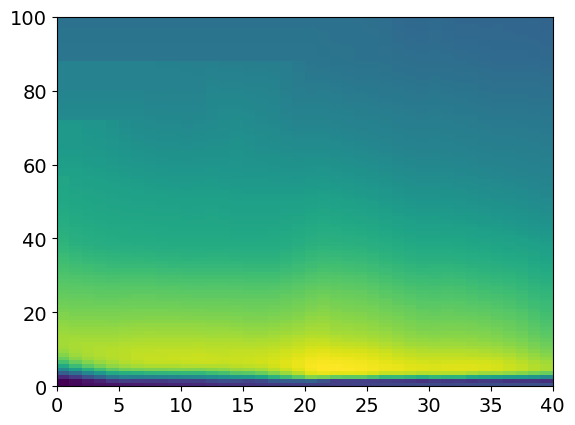

In [15]:
plt.pcolormesh(T_int.isel(x=0))

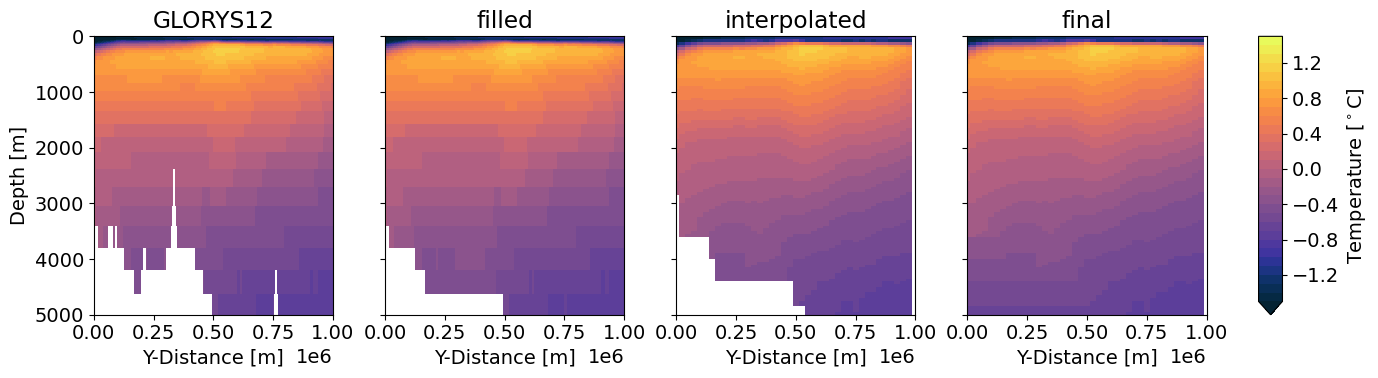

In [16]:
fig,axes=plt.subplots(1,5,figsize=(14,4),gridspec_kw=({'width_ratios':[1,1,1,1,.1]}))
ax=axes[0]
ds.votemper.isel(x=0).plot.pcolormesh(cmap=cmo.thermal,ax=ax,vmin=-1.5,vmax=1.5, levels=31,add_colorbar=False)
ax.set_title('GLORYS12')
ax.set_ylim(0,5000)
ax.invert_yaxis()
ax.set_ylabel('Depth [m]')
ax.set_xlim(0,1e6)
ax.set_xlabel('Y-Distance [m]')
ax=axes[1]
dsf.votemper.isel(x=0).plot.pcolormesh(cmap=cmo.thermal,ax=ax,vmin=-1.5,vmax=1.5, levels=31,add_colorbar=False)
ax.set_title('filled')
ax.set_ylim(0,5000)
ax.invert_yaxis()
ax.set_yticklabels('')
ax.set_ylabel('')
ax.set_xlim(0,1e6)
ax.set_xlabel('Y-Distance [m]')
ax=axes[2]
dsi.votemper.isel(x=0).plot.pcolormesh(cmap=cmo.thermal,ax=ax,vmin=-1.5,vmax=1.5, levels=31,add_colorbar=False)
ax.set_title('interpolated')
ax.set_ylim(0,5000)
ax.invert_yaxis()
ax.set_yticklabels('')
ax.set_ylabel('')
ax.set_xlim(0,1e6)
ax.set_xlabel('Y-Distance [m]')
ax=axes[3]
cb=T_int.isel(x=0).plot.pcolormesh(cmap=cmo.thermal,ax=ax,vmin=-1.5,vmax=1.5, levels=31,add_colorbar=False)
ax.set_title('final')
ax.set_ylim(0,5000)
ax.invert_yaxis()
ax.set_yticklabels('')
ax.set_ylabel('')
ax.set_xlim(0,1e6)
ax.set_xlabel('Y-Distance [m]')

plt.colorbar(cb,cax=axes[4],label="Temperature [$^\circ$C]")
plt.tight_layout()
plt.savefig('./manipulated_T_ForMITGCM.png',dpi=300)

Text(0.5, 1.0, 'Original- density section')

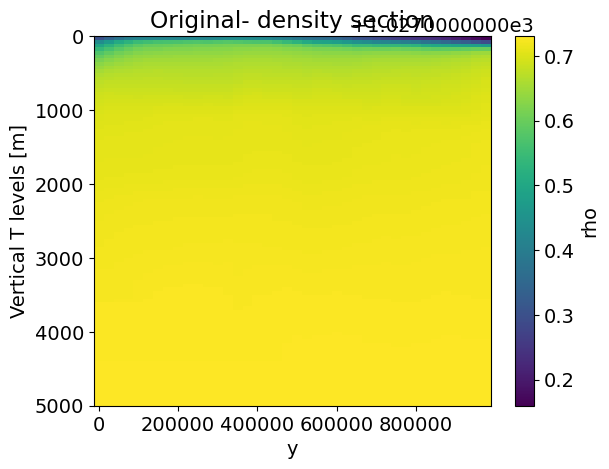

In [17]:
#p=gsw.p_from_z(-1*dsr.deptht,-65)
dsi["rho"]=gsw.rho(S_int,T_int,0)
plt.figure()
dsi.rho.isel(x=0).plot.pcolormesh()
plt.gca().invert_yaxis()
plt.title('Original- density section')

In [18]:
rho=dsi.rho.isel(x=0)
rho.load()

<xarray.DataArray 'rho' (deptht: 100, y: 40)>
array([[1027.30380003, 1027.3432846 , 1027.38012402, ..., 1027.19013355,
        1027.17400293, 1027.15955373],
       [1027.43480177, 1027.47056327, 1027.50543577, ..., 1027.32815821,
        1027.30722056, 1027.28958411],
       [1027.49706598, 1027.52594323, 1027.55275283, ..., 1027.48708125,
        1027.48036476, 1027.47142537],
       ...,
       [1027.72985906, 1027.72985906, 1027.72985906, ..., 1027.73038089,
        1027.73046421, 1027.7306753 ],
       [1027.72986223, 1027.72986223, 1027.72986223, ..., 1027.73039422,
        1027.73049171, 1027.73069713],
       [1027.72986539, 1027.72986539, 1027.72986539, ..., 1027.73040754,
        1027.73051917, 1027.73071894]])
Coordinates:
    nav_lon    (y) float64 15.5 15.5 15.5 15.5 15.5 ... 15.5 15.5 15.5 15.5 15.5
    x          int32 3632
    cumdist_y  (y) float64 0.0 2.5e+04 5e+04 ... 9.25e+05 9.5e+05 9.75e+05
    nav_lat    (y) float64 -68.79 -68.57 -68.34 -68.12 ... -60.47 -60.25 -60.02
  * y          (y) float64 0.0 2.5e+04 5e+04 ... 9.25e+05 9.5e+05 9.75e+05
  * deptht     (deptht) float64 25.0 75.0 125.0 ... 4.925e+03 4.975e+03

In [19]:
CT=gsw.CT_from_rho(rho, 35,0)
T_equi=CT[0]
T_mult=CT[1]

In [21]:
T_equi.to_netcdf('Tequi_G12_MIT.nc')

In [22]:
#(60, 100, 40) obcs

T_3Di=np.zeros((nr,ny,nx))
for i in range(0,nx):
    T_3Di[:,:,i]=T_equi
    
T_3Dobcs=np.zeros((nx,nr,ny))
for i in range(0,nx):
    T_3Dobcs[i,:,:]=T_equi


In [23]:
T_3Di.astype('>f4').tofile(f'T5000_ini_realistic_{len(dr)}_25km.bin')
T_3Dobcs.astype('>f4').tofile(f'T5000_obcs_realistic_{len(dr)}_25km.bin')

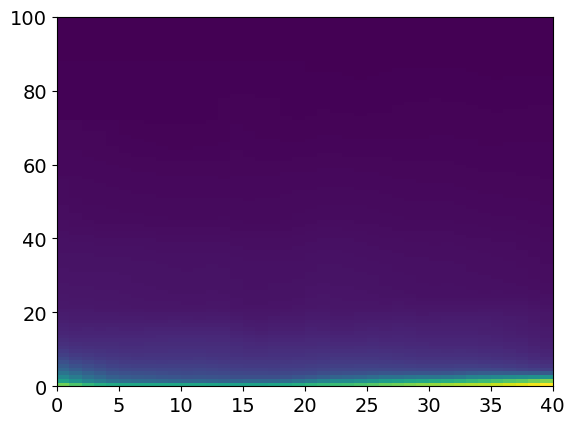

In [24]:
plt.pcolormesh(T_3Di[:,:,35])

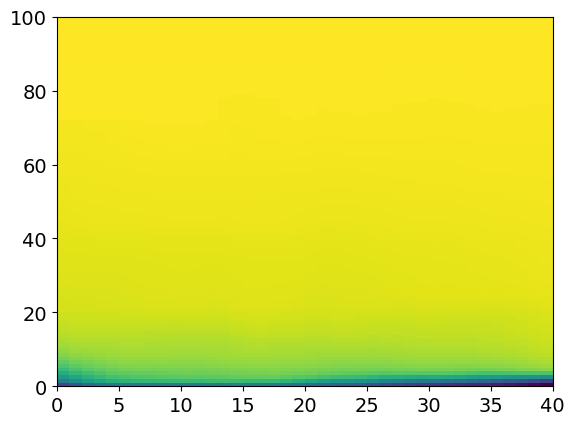

In [25]:
rho=rho0- rho0*alpha0*T_3Di
plt.pcolormesh(rho[:,:,35])

<xarray.DataArray 'U_from_T' ()>
array(0.00071877)
Coordinates:
    x        int64 59
(60, 100, 40)


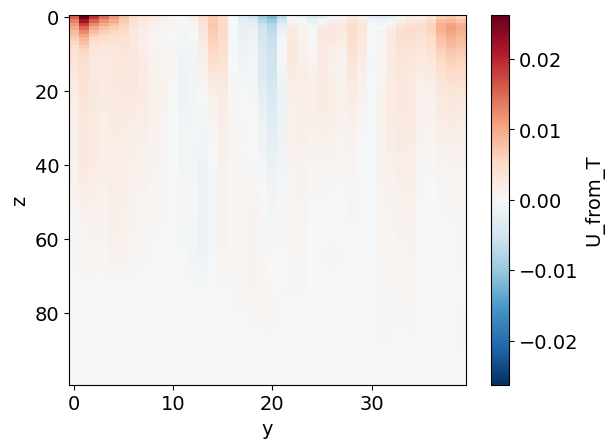

In [26]:
# derive the thermal wind based on a linear EOS

rho=rho0- rho0*alpha0*T_3Di

dsm = xr.Dataset()
dsm['rho'] = (('z', 'y', 'x'), rho)
dsm = dsm.assign_coords(x=dsm.x, y=dsm.y, z=dsm.z)
dsm.x.attrs['axis'] = 'X'
dsm.y.attrs['axis'] = 'Y'
dsm.z.attrs['axis'] = 'Z'
dsm = xgcm.generate_grid_ds(dsm, {'X':'x', 'Y':'y', 'Z':'z'})
grid = xgcm.Grid(dsm, periodic=False)
dsm['dr'] = ('z', dr)
dsm["T_3D"]=(('z', 'y', 'x'),T_3Di)

rev = -1*(g/f)*grid.cumsum(
    (
        grid.interp(1/dsm.rho, 'Y', boundary='extend') * grid.diff(dsm.rho, 'Y', boundary='extend') / (dy*10**3)
    ) * dsm.dr,
    'Z',
    boundary='fill',
    fill_value=0
)

velocity = rev.isel(z_left=-1) - rev
dsm['U_from_T'] = grid.interp(velocity, ['Y', 'Z'], boundary='extend')
dsm.U_from_T.mean('x').plot(y='z', yincrease=False)
print(dsm.U_from_T.isel(x=59).mean(dim={'y','z'}))

U_tw=np.asarray(dsm.U_from_T.transpose("x", "z", "y"))
print(U_tw.shape)

U_tw.astype('>f4').tofile(f'Uvel5000_tw_realistic_xzy_{len(dr)}_25km.bin') # I assume the x dimension is read as t dimension 

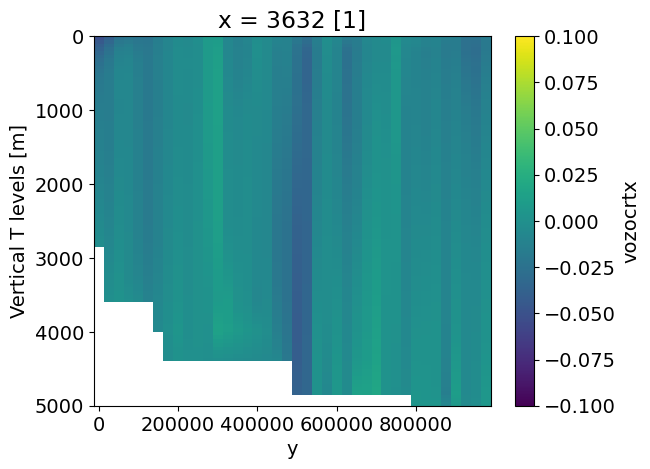

In [27]:
# model mean u
dsi.vozocrtx.isel(x=0).plot.pcolormesh(vmin=-0.1,vmax=0.1)
plt.gca().invert_yaxis()

-0.008073972641525767


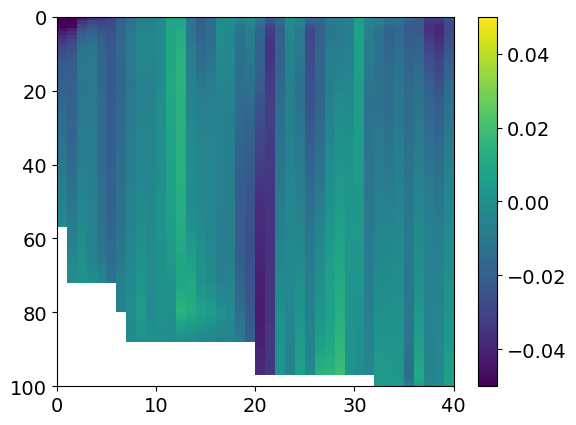

In [28]:
# u_baro= (u_model mean - u-from T) mean along (y,z)
dsm.load()
dsi.load()
u=dsi.vozocrtx.isel(x=0).data-dsm.U_from_T.isel(x=1).T.data

plt.figure()
plt.pcolormesh(u[:,:],vmin=-0.05,vmax=0.05)
plt.gca().invert_yaxis()
plt.colorbar()

u_baro=np.nanmean(u)
print(u_baro)

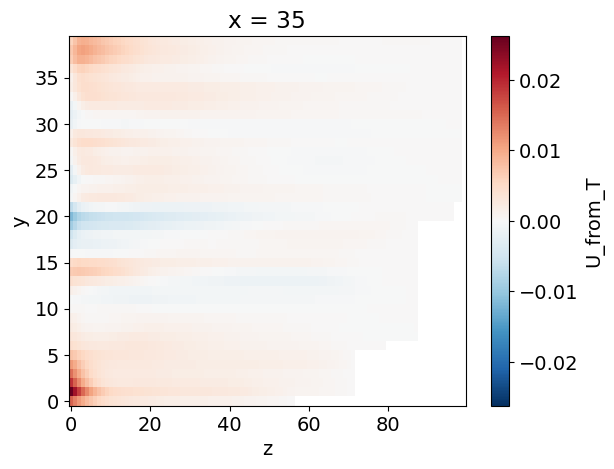

In [29]:
dsm.U_from_T.where(dsm.U_from_T!=0).isel(x=35).plot.pcolormesh()


In [30]:
U_BC=dsm.U_from_T.where(dsm.U_from_T!=0).mean()
U_BT=u_baro
print(np.round(U_BC,4),np.round(U_BT,4))

print(U_BC/U_BT)


<xarray.DataArray 'U_from_T' ()>
array(0.0008) -0.0081
<xarray.DataArray 'U_from_T' ()>
array(-0.09845006)


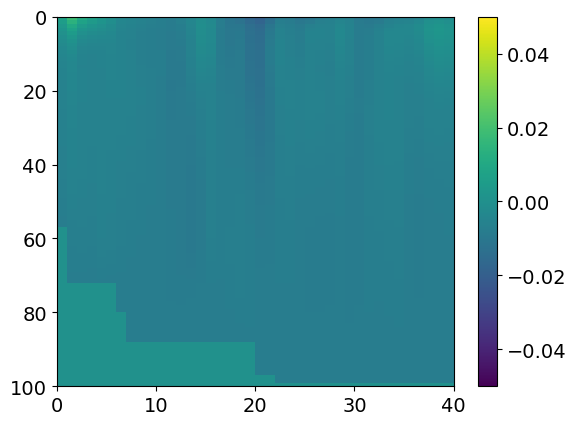

In [31]:
#u_model=U_tw[35,:,:]*0
u_model=dsm.U_from_T.where(dsm.U_from_T!=0, other=-u_baro).isel(x=35)+u_baro
#u_model=dsm.U_from_T.isel(x=35)+u_baro
plt.pcolormesh(u_model[:,:].T,vmin=-0.05,vmax=0.05)
plt.gca().invert_yaxis()
plt.colorbar()

In [32]:
print(u_model.mean().values)
print(dsi.vozocrtx.isel(x=0).fillna(0).mean().values)

-0.006582116761283756
-0.006557923034902013


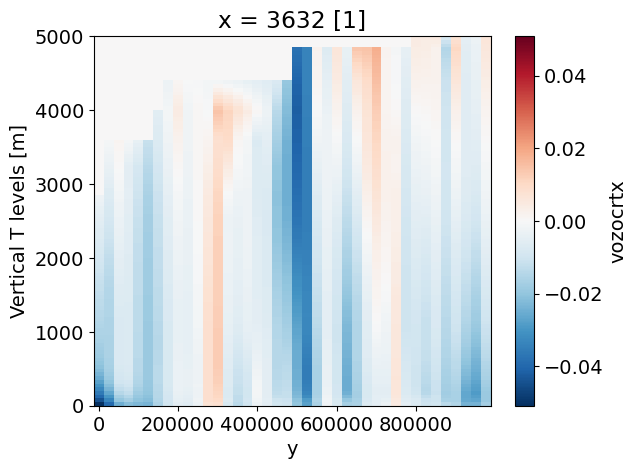

In [33]:
dsi.vozocrtx.isel(x=0).fillna(0).plot.pcolormesh()

In [34]:
u_mod_3D=np.zeros(T_3Dobcs.shape)
u_mod_3D.shape
for j in range(0,nx):
    u_mod_3D[j,:,:]=u_model.T

In [37]:
u_model

<xarray.DataArray 'U_from_T' (y: 40, z: 100)>
array([[ 7.32778342e-03,  5.18930312e-03,  3.23105984e-03, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 1.81593129e-02,  1.39294267e-02,  1.00564998e-02, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 1.08483619e-02,  7.42788297e-03,  4.25979207e-03, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       ...,
       [-1.63186198e-03, -1.23558557e-05,  1.15706146e-03, ...,
        -8.05509040e-03, -8.06753822e-03,  0.00000000e+00],
       [-1.07554737e-03,  7.36744673e-04,  2.25366351e-03, ...,
        -8.03898629e-03, -8.06220040e-03,  0.00000000e+00],
       [-2.20389014e-03, -5.31882481e-04,  9.55869681e-04, ...,
        -8.02562933e-03, -8.05800500e-03,  0.00000000e+00]])
Coordinates:
    x        int64 35
  * y        (y) int64 0 1 2 3 4 5 6 7 8 9 10 ... 30 31 32 33 34 35 36 37 38 39
  * z        (z) int64 0 1 2 3 4 5 6 7 8 9 10 ... 90 91 92 93 94 95 96 97 98 99

(60, 100, 40)


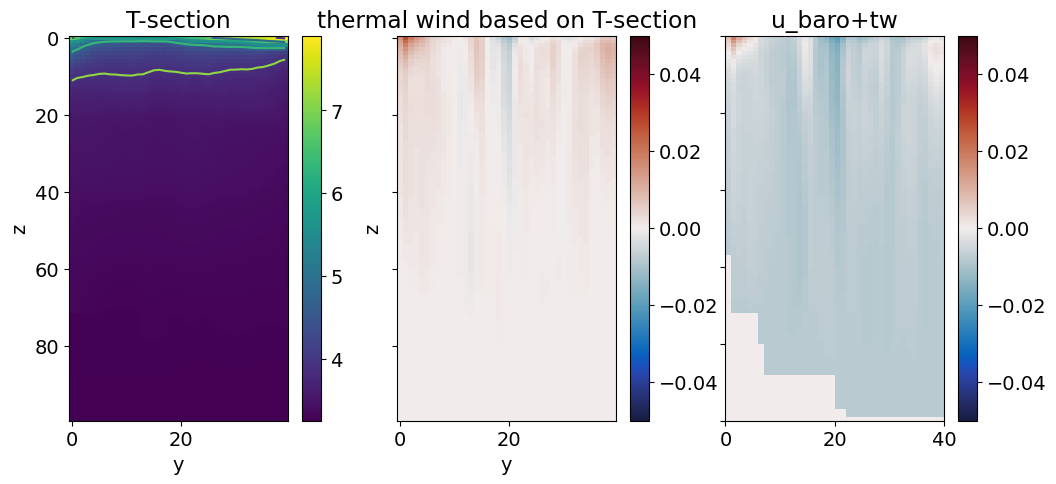

In [36]:
print(u_mod_3D.shape)

fig,axes=plt.subplots(1,3,figsize=(12,5))
ax=axes[0]
cbt=dsm.T_3D.isel(x=35).plot.pcolormesh(x="y",y="z",ax=ax,add_colorbar=False)
dsm.rho.isel(x=35).plot.contour(x="y",y="z",ax=ax)
ax.invert_yaxis()
ax.set_title('T-section')
plt.colorbar(cbt,ax=ax)

ax=axes[1]
cbu=dsm.U_from_T.isel(x=35).plot.pcolormesh(x="y",y="z",vmin=-0.05,vmax=0.05,ax=ax,cmap=cmo.balance,add_colorbar=False)
ax.invert_yaxis()
ax.set_yticklabels('')
ax.set_title('thermal wind based on T-section')
plt.colorbar(cbu,ax=ax)

ax=axes[2]
cbu=ax.pcolormesh(u_mod_3D[35,:,:],vmin=-0.05,vmax=0.05,cmap=cmo.balance)
ax.invert_yaxis()
ax.set_yticklabels('')
ax.set_title('u_baro+tw')
plt.colorbar(cbu,ax=ax)
u_mod_3D.astype('>f4').tofile(f'Uvel5000_utw_realistic_xzy_{len(dr)}_25km.bin') # I assume the x dimension is read as t dimension 